In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
qml.drawer.use_style(style='sketch')

In [3]:
from pennylane.operation import Operation

class Oracle(Operation):
    num_params = 2
    num_wires = qml.operation.AnyWires

    @staticmethod
    def compute_decomposition(N, seed, wires):
        # Set seed for np.random
        np.random.seed(seed)
        gates = []
        
        # Choose N qubits to apply X gate
        N_X = np.random.randint(1, N)
        target_qubits = np.random.choice(N, size=N_X, replace=False)
        for i in range(N_X):
            gates.append(qml.PauliX(wires=wires[target_qubits[i] + N]))

        p_scenario = np.random.randint(2)
        # CNOT(N - 1 -> N - 1)
        if p_scenario == 0:
            # Choose N - 1 qubits to apply CNOT
            input_qubits = np.random.choice(N, size=N - 1, replace=False)
            target_qubits = np.random.choice(N, size=N - 1, replace=False)

            input_unique = np.unique(input_qubits)
            target_unique = np.unique(target_qubits)

            N_additional = np.random.randint(1, N)
            input_additional = np.random.choice(input_unique, size=N_additional, replace=True)
            target_additional = np.random.choice(target_unique, size=N_additional, replace=True)

            input_qubits = np.concatenate((input_qubits, input_additional))
            target_qubits = np.concatenate((target_qubits, target_additional))

            # Make the HashSet of input_qubits and target_qubits to guarantee that there is no duplicate
            qubit_set = set()
            for i in range(N-1 + N_additional):
                qubit_set.add((input_qubits[i], target_qubits[i] + N))

            for i, t in qubit_set:
                gates.append(qml.CNOT(wires=[wires[i], wires[t]]))
        
        # CNOT(N -> N - 1)
        else:
            # Choose N, N - 1 qubits to apply CNOT
            input_qubits = np.random.choice(N, size=N, replace=False)
            target_qubits = np.random.choice(N, size=N - 1, replace=False)

            input_unique = np.unique(input_qubits)
            target_unique = np.unique(target_qubits)

            N_additional = np.random.randint(1, N)
            input_additional = np.random.choice(input_unique, size=N_additional, replace=True)
            target_additional = np.random.choice(target_unique, size=N_additional + 1, replace=True)

            input_qubits = np.concatenate((input_qubits, input_additional))
            target_qubits = np.concatenate((target_qubits, target_additional))

            # Make the HashSet of input_qubits and target_qubits to guarantee that there is no duplicate
            qubit_set = set()
            for i in range(N-1 + N_additional):
                qubit_set.add((input_qubits[i], target_qubits[i] + N))

            for i, t in qubit_set:
                gates.append(qml.CNOT(wires=[wires[i], wires[t]]))

        return gates

**Explanation of the Oracle**

We want to make the oracle which satisfies the following conditions:

- Suppose $f(x)$ is a function which takes $n$-bit string $x$ as input and returns $n$-bit string $y$ as output.

- For secret string $s$, $x \neq y$ and $f(x) = f(y)$ implies $x \oplus s = y$ for all $x$ and $y$.

- For input $|x\rangle|y\rangle$, the oracle returns $|x\rangle|y\oplus f(x)\rangle$.

To cover all the possible cases is a hard task. So, here, we consider the case where $U_f$ is composed of $X$ gates and $\text{CNOT}$ gates.

- $X$ gate can be placed at any position of the answer qubits.

- $\text{CNOT}$ gate can be placed at one of input qubits and one of the answer qubits.

- Because of the condition, there are $2^{n-1}$ unique outputs of $f(x)$. (Half of outputs are duplicated.)

- To constrain the degree of freedom, we should control $N-1$ qubits of the answer qubits by at least $N-1$ qubits of the input qubits.

- And it is possible to place $\text{CNOT}(i, a)$, $\text{CNOT}(j, a)$ if $i \neq j$.

In [4]:
N = 3
seed = 7
dev = qml.device('default.qubit', wires=2*N, shots=1000)

@qml.qnode(dev)
def oracle_test(state):
    qml.BasisStatePreparation(state, wires=range(N))
    Oracle(N, seed, wires=range(2*N))
    return qml.counts(wires=range(N, 2*N))

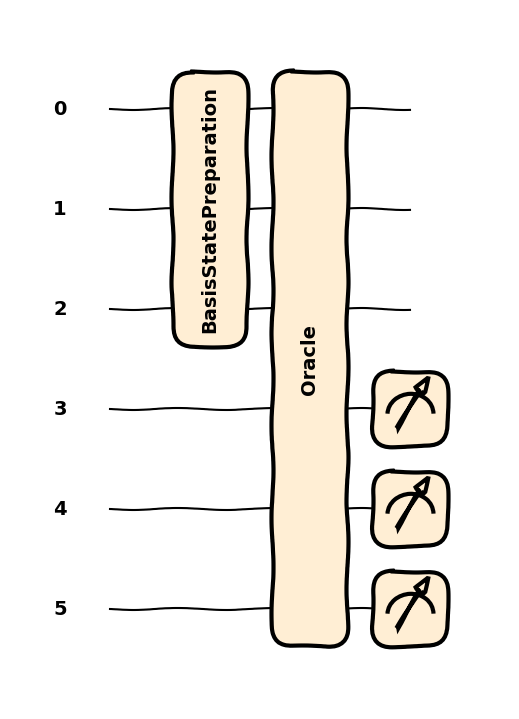

In [5]:
qml.draw_mpl(oracle_test)(np.zeros(N))
plt.show()

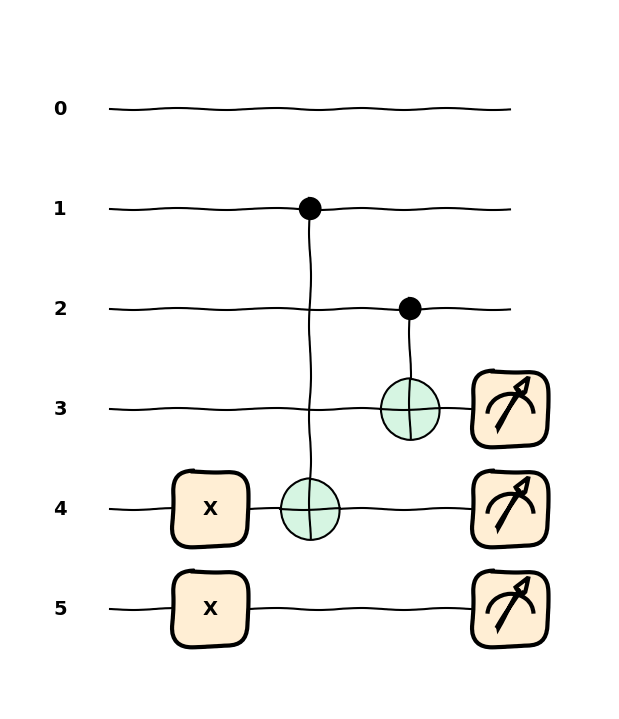

In [6]:
qml.draw_mpl(oracle_test, show_all_wires=True, expansion_strategy='device')(np.zeros(N))
plt.show()

In [7]:
basis_states = [f"{i:0{N}b}" for i in range(2**N)]
basis_states = [list(map(int, list(state))) for state in basis_states]
basis_states

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [8]:
results = []
for state in basis_states:
    # output computational basis to z basis
    result = oracle_test(state)
    # get key of the result when value is maximum
    key = max(result, key=result.get)
    # string to list
    key = list(map(int, list(key)))
    results.append(key)
    print(f"Input: {state} Output: {key}")

Input: [0, 0, 0] Output: [0, 1, 1]
Input: [0, 0, 1] Output: [1, 1, 1]
Input: [0, 1, 0] Output: [0, 0, 1]
Input: [0, 1, 1] Output: [1, 0, 1]
Input: [1, 0, 0] Output: [0, 1, 1]
Input: [1, 0, 1] Output: [1, 1, 1]
Input: [1, 1, 0] Output: [0, 0, 1]
Input: [1, 1, 1] Output: [1, 0, 1]


In [9]:
basis_states = np.array(basis_states)
results = np.array(results)

In [10]:
index = 0
for i in range(1, results.shape[0]):
    if np.array_equal(results[i], results[0]):
        index = i
        break

s = basis_states[index]
s

tensor([1, 0, 0], requires_grad=True)

In [11]:
@qml.qnode(dev)
def oracle_test(state, seed):
    qml.BasisStatePreparation(state, wires=range(N))
    Oracle(N, seed, wires=range(2*N))
    return qml.counts(wires=range(N, 2*N))

In [12]:
def find_s_semi_classical(n):
    s_vec = []
    for seed in range(n):
        results = []
        for state in basis_states:
            # output computational basis to z basis
            result = oracle_test(state, seed)
            key = max(result, key=result.get)
            key = list(map(int, list(key)))
            results.append(key)
        results = np.array(results)
        index = 0
        for i in range(1, results.shape[0]):
            if np.array_equal(results[i], results[0]):
                index = i
                break
        s_vec.append(basis_states[index])
    return np.array(s_vec)

In [13]:
s_vec = find_s_semi_classical(50) # Too slow

In [14]:
s_num_vec = np.sum(s_vec * np.array([4, 2, 1]), axis=1)

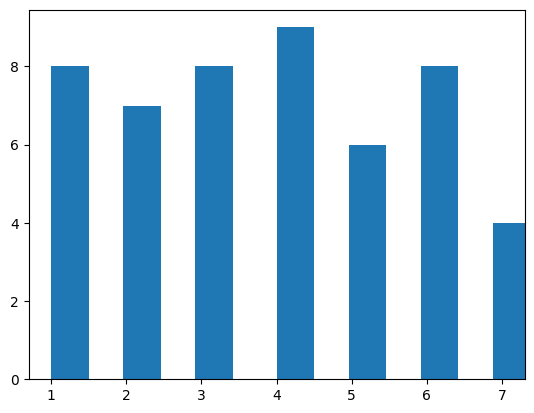

In [15]:
# Plot the histogram
plt.hist(s_num_vec, bins=50, width=0.5)
plt.show()

In [16]:
import ray
ray.init()

2023-12-20 11:09:04,831	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.6
Ray version:,2.8.1


In [17]:
@ray.remote
def find_s_semi_classical_parallel(n):
    seed = n
    results = []
    for state in basis_states:
        # output computational basis to z basis
        result = oracle_test(state, seed)
        key = max(result, key=result.get)
        key = list(map(int, list(key)))
        results.append(key)
    results = np.array(results)
    index = 0
    for i in range(1, results.shape[0]):
        if np.array_equal(results[i], results[0]):
            index = i
            break
    return basis_states[index]

In [18]:
s_vec = ray.get([find_s_semi_classical_parallel.remote(n) for n in range(1000)])
s_vec = np.array(s_vec)
s_num_vec = np.sum(s_vec * np.array([4, 2, 1]), axis=1)

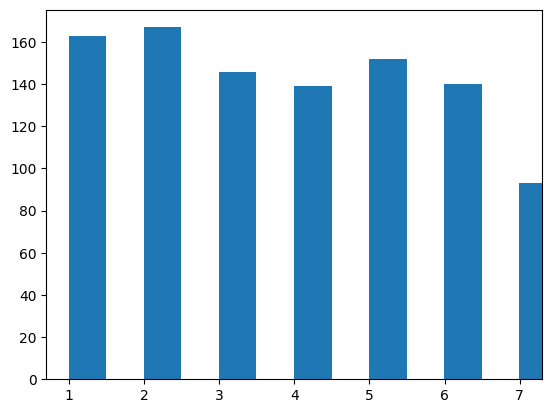

In [19]:
# Plot the histogram
plt.hist(s_num_vec, bins=1000, width=0.5)
plt.show()

## Simon's Algorithm

In [20]:
def gen_simon(n):
    dev = qml.device('default.qubit', wires=2*n, shots=1)

    @qml.qnode(dev)
    def circuit(seed):
        # Apply Hadamard to the first n qubits (input qubits)
        for i in range(n):
            qml.Hadamard(wires=i)

        # Add barrier
        qml.Barrier(wires=range(2*n))

        # Apply oracle
        Oracle(n, seed, wires=range(2*n))

        # Add barrier
        qml.Barrier(wires=range(2*n))

        # Apply Hadamard to the first n qubits (input qubits)
        for i in range(n):
            qml.Hadamard(wires=i)

        # Measure all qubits
        return qml.counts(wires=range(2*n))
    
    return dev, circuit

In [21]:
dev, circuit = gen_simon(3)

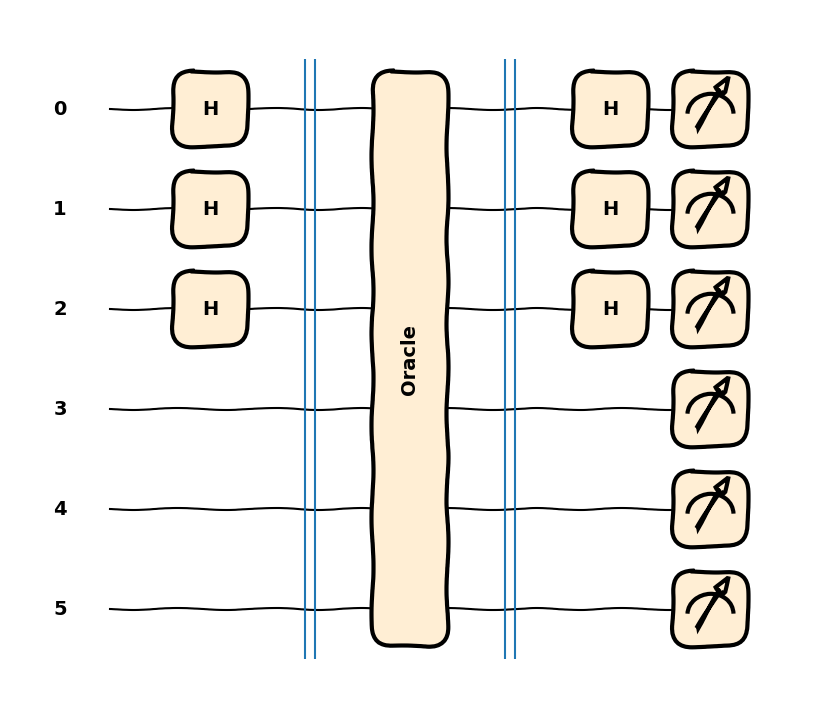

In [22]:
qml.draw_mpl(circuit)(0)
plt.show()

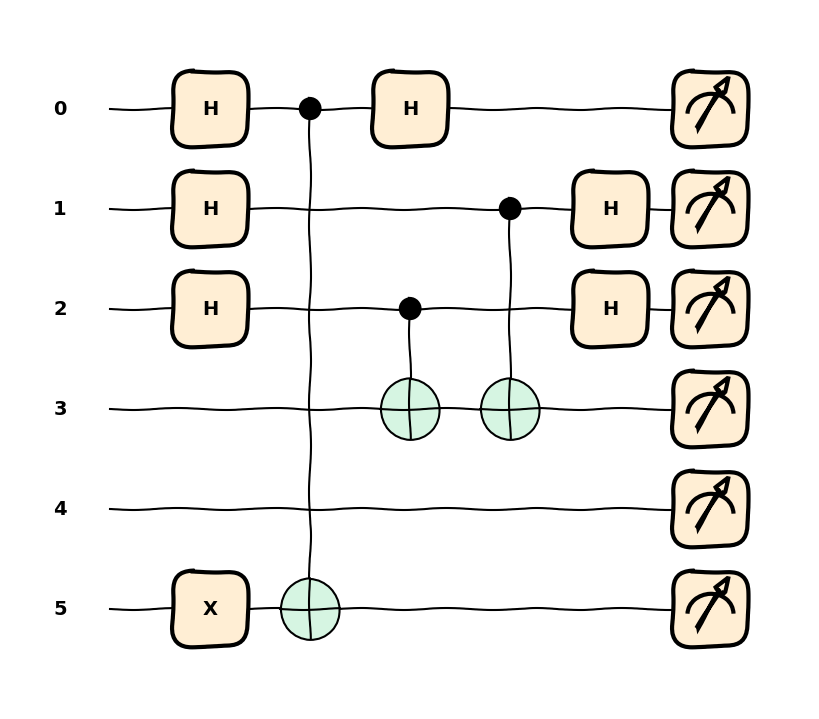

In [23]:
qml.draw_mpl(circuit, show_all_wires=True, expansion_strategy='device')(0)
plt.show()

**Explanation of the circuit**

1) Apply Hadamard gates to the input qubits.
   $$
   |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n} \xrightarrow{H^{\otimes n} \otimes I^{\otimes n}} \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} |x\rangle \otimes |0\rangle^{\otimes n}
   $$

2) Apply the oracle.
   $$
   \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} |x\rangle \otimes |0\rangle^{\otimes n} \xrightarrow{U_f} \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} |x\rangle \otimes |f(x)\rangle
   $$

3) Measure the answer qubits.
   $$
   \frac{1}{\sqrt{2^n}}\sum_{x=0}^{2^n-1} |x\rangle \otimes |f(x)\rangle \xrightarrow{\text{Measure answer qubits as } |f(x)\rangle} \frac{1}{\sqrt{2}}(|x\rangle + |x\oplus s\rangle) \otimes |f(x')\rangle
   $$

4) Apply Hadamard gates to the input qubits. (we omit the answer qubits.)
   $$
   \frac{1}{\sqrt{2}}(|x\rangle + |x \oplus s\rangle) \xrightarrow{H^{\otimes n}} \frac{1}{\sqrt{2^{n+1}}}\sum_{z=0}^{2^n-1} [(-1)^{x \cdot z} + (-1)^{(x \oplus s) \cdot z}] |z\rangle
   $$

5) Measure the input qubits. (Suppose we get $|z\rangle$ - It means we get $z$ as $n$-bit string.)
   $$
   \begin{aligned}
   |\langle z | \psi \rangle|^2 &= \frac{1}{2^{n+1}} \left|[(-1)^{x \cdot z} + (-1)^{(x \oplus s) \cdot z}] \right|^2 \\
   &= \frac{1}{2^{n+1}} \left| (-1)^{x \cdot z} \left[ 1 + (-1)^{s \cdot z} \right] \right|^2 \\
   &= \frac{1}{2^{n+1}} \left| 1 + (-1)^{s \cdot z} \right|^2 \\
   &= \begin{cases}
   0 & \text{if } s \cdot z = 1 \\
   \frac{1}{2^{n-1}} & \text{if } s \cdot z = 0
   \end{cases}
   \end{aligned}
   $$

6) Repeat the above procedure until we get $n-1$ linearly independent $z_i$'s such that $s \cdot z_i = 0$.

7) Solve the linear equation $s \cdot z_i = 0$ to get $s$.

In [24]:
n = 3
dev, circuit = gen_simon(n)

In [25]:
seed = 0
linearly_independents = set()
total_queries = 0
while len(linearly_independents) < n-1:
    result = circuit(seed)
    key = max(result, key=result.get)[:n]
    if key == '0' * n:
        continue
    elif key not in linearly_independents:
        linearly_independents.add(key)
    total_queries += 1

print(f"Linearly independent strings: {linearly_independents}")
print(f"Total queries: {total_queries}")

Linearly independent strings: {'011', '111'}
Total queries: 2


In [26]:
def find_nonzero_orthogonal_vector(z_strings):
    z_vectors = []
    for z in z_strings:
        z_vec = []
        for i in range(len(z)):
            z_vec.append(int(z[i]))
        z_vectors.append(z_vec)
    Z = np.array(z_vectors)
    m = Z.shape[1]

    for i in range(1, 2**m):
        s = np.array([int(c) for c in bin(i)[2:].zfill(m)])

        if all(np.dot(s, z) % 2 == 0 for z in Z):
            return s
        
    return None

In [27]:
find_nonzero_orthogonal_vector(linearly_independents)

tensor([0, 1, 1], requires_grad=True)

In [28]:
def simon_algorithm(n, seed):
    dev, circuit = gen_simon(n)

    linearly_independents = set()
    total_queries = 0
    while len(linearly_independents) < n-1:
        result = circuit(seed)
        key = max(result, key=result.get)[:n]
        if key == '0' * n:
            continue
        elif key not in linearly_independents:
            linearly_independents.add(key)
        total_queries += 1
    
    s = find_nonzero_orthogonal_vector(linearly_independents)
    s = ''.join(map(str, s))
    
    print(f"Linearly independent strings: {linearly_independents}")
    print(f"Secret string: {s}")
    print(f"Total queries: {total_queries}")

In [29]:
simon_algorithm(2, 0)

Linearly independent strings: {'11'}
Secret string: 11
Total queries: 1


In [30]:
simon_algorithm(4, 0)

Linearly independent strings: {'1110', '1100', '1001'}
Secret string: 1101
Total queries: 3


In [31]:
@ray.remote
def simon_algorithm_bench(n):
    dev, circuit = gen_simon(n)

    linearly_independents = set()
    total_queries = 0
    while len(linearly_independents) < n-1:
        result = circuit(42)
        key = max(result, key=result.get)[:n]
        if key == '0' * n:
            continue
        elif key not in linearly_independents:
            linearly_independents.add(key)
        total_queries += 1
    
    return total_queries

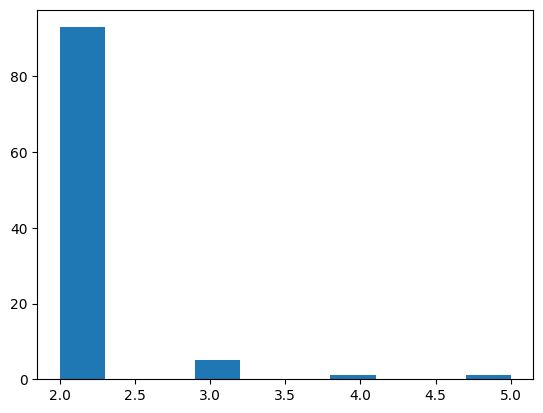

In [32]:
total_queries = ray.get([simon_algorithm_bench.remote(3) for _ in range(100)])
plt.hist(total_queries)
plt.show()

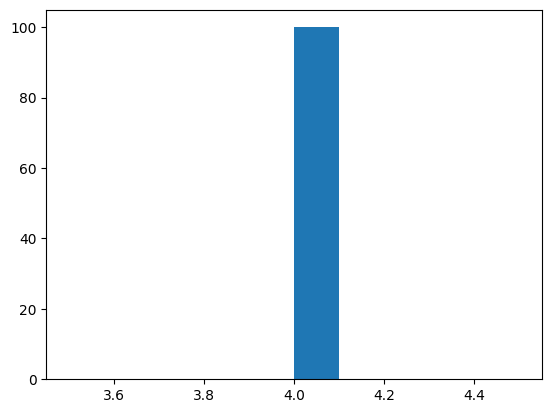

In [33]:
total_queries = ray.get([simon_algorithm_bench.remote(5) for _ in range(100)])
plt.hist(total_queries)
plt.show()

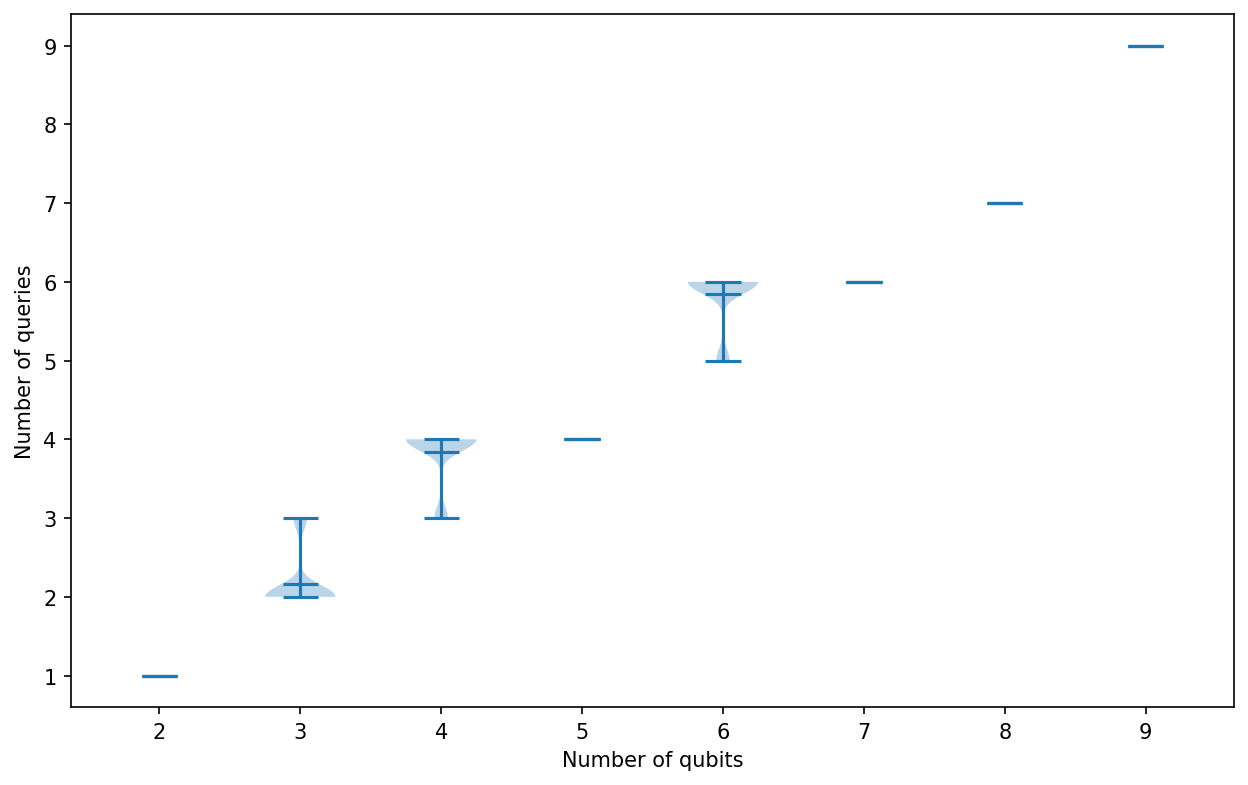

In [36]:
results = []
for n in range(2, 10):
    total_queries = ray.get([simon_algorithm_bench.remote(n) for _ in range(100)])
    results.append(total_queries)

plt.figure(figsize=(10, 6), dpi=150)
plt.violinplot(results, showmeans=True)
plt.xticks(range(1, 9), range(2, 10))
plt.xlabel('Number of qubits')
plt.ylabel('Number of queries')
plt.show()